# Neural Dependency Parsing
Francesco Cazzaro, Universitat Politècnica De Catalunya

## Introduction

Transition-based dependency parsing is one of the most popular methods for implementing a dependency parsers.  We use here the **arc-standard** model, that has been presented in class. We augment the parser with neural machinery for contextual word embeddings and for choosing the most appropriate parser actions.  

We implement the following features:
* LSTM representation for stack tokens
* MLP for next transition classification, based on two top-most stack tokens and first token in the buffer
* training under static oracle

In order to keep the presentation at a simple level, we disregard arc labels in dependency trees. 

The reference paper is: 
> Kiperwasser and Goldberg, Simple and Accurate Dependency Parsing Using Bidirectional LSTM Feature Representations  
*Transactions of the Association for Computational Linguistics*, Volume 4, 2016.

Differently from this notebook, the original paper uses a model called **arc-hybrid**. 

In [1]:
!pip install datasets  # huggingface library with dataset
!pip install conllu    # aux library for processing CoNLL-U format

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.7/468.7 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.2/224.2 kB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 kB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 269.3/269.3 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 kB 15.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import torch
import torch.nn as nn
from functools import partial
from datasets import load_dataset

## Arc-standard

Recall that a **configuration** of the arc-standard parser is a triple of the form $( \sigma, \beta, A)$
where:

* $\sigma$ is the stack;
* $\beta$ is the input buffer;
* $A$ is a set of arcs constructed so far.

We write $\sigma_i$, $i \geq 1$, for the $i$-th token in the stack; we also write $\beta_i$, $i \geq 1$, for the $i$-th token in the buffer. 

The parser can perform three types of **actions** (transitions):

* **shift**, which removes $\beta_1$ from the buffer and pushes it into the stack;
* **left-arc**, which creates the arc $(\sigma_1 \rightarrow \sigma_2)$, and removes $\sigma_2$ from the stack;
* **right-arc**, which creates the arc $(\sigma_2 \rightarrow \sigma_1)$, and removes $\sigma_1$ from the stack.

Let $w = w_0 w_1 \cdots w_{n}$ be the input sentence, with $w_0$ the special symbol `<ROOT>`.
Stack and buffer are implemented as lists of integers, where `j` represents word $w_j$.  Top-most stack token is at the right-end of the list; first buffer token is at the left-end of the list. 
Set $A$ is implemented as an array `arcs` of size $n+1$ such that if arc $(w_i \rightarrow w_j)$ is in $A$ then `arcs[j]=i`, and if $w_j$ is still missing its head node in the tree under construction, then `arcs[j]=-1`. We always have `arcs[0]=-1`.  We use this representation also for complete dependency trees.


In [3]:
class ArcStandard:
  def __init__(self, sentence):
    self.sentence = sentence
    self.buffer = [i for i in range(len(self.sentence))]
    self.stack = []
    self.arcs = [-1 for _ in range(len(self.sentence))]

    # three shift moves to initialize the stack
    self.shift()
    self.shift()
    if len(self.sentence) > 2:
      self.shift()

  def shift(self):
    b1 = self.buffer[0]
    self.buffer = self.buffer[1:]
    self.stack.append(b1)

  def left_arc(self):
    o1 = self.stack.pop()
    o2 = self.stack.pop()
    self.arcs[o2] = o1
    self.stack.append(o1)
    if len(self.stack) < 2 and len(self.buffer) > 0:
      self.shift()

  def right_arc(self):
    o1 = self.stack.pop()
    o2 = self.stack.pop()
    self.arcs[o1] = o2
    self.stack.append(o2)
    if len(self.stack) < 2 and len(self.buffer) > 0:
      self.shift()

  def is_tree_final(self):
    return len(self.stack) == 1 and len(self.buffer) == 0

  def print_configuration(self):
    s = [self.sentence[i] for i in self.stack]
    b = [self.sentence[i] for i in self.buffer]
    print(s, b)
    print(self.arcs)  

We now do a few manual tests on the parser.  Consider the sentence `He began to write again .` and the associated dependency tree
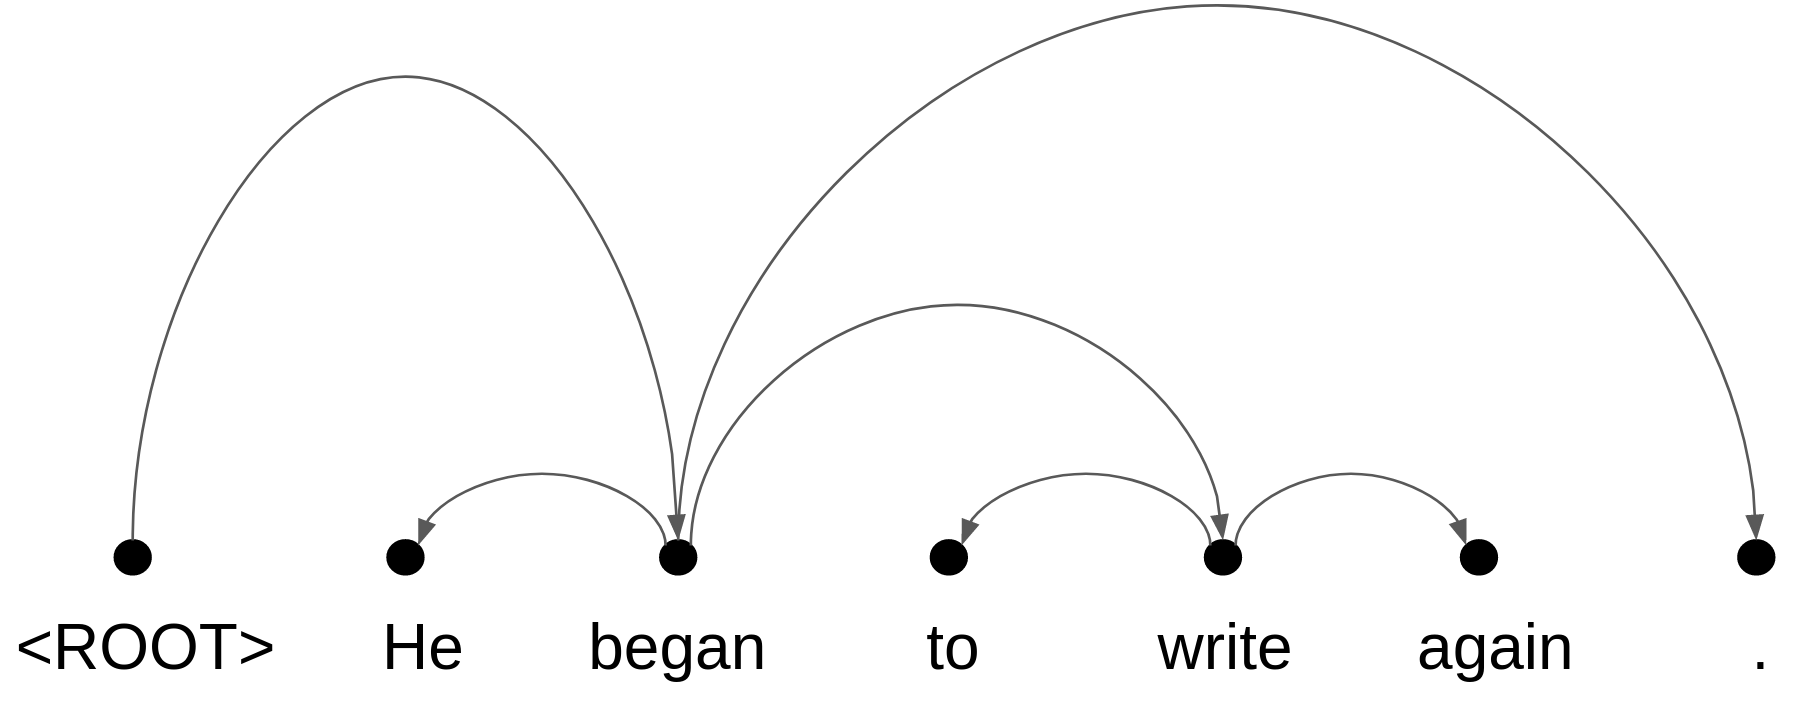

In [4]:
sentence = ["<ROOT>", "He", "began", "to", "write", "again", "."]
gold = [-1, 2, 0, 4, 2, 4, 2 ]

parser = ArcStandard(sentence)
parser.print_configuration()

['<ROOT>', 'He', 'began'] ['to', 'write', 'again', '.']
[-1, -1, -1, -1, -1, -1, -1]


In [5]:
parser.left_arc()
parser.print_configuration()

['<ROOT>', 'began'] ['to', 'write', 'again', '.']
[-1, 2, -1, -1, -1, -1, -1]


In [6]:
parser.shift()
parser.print_configuration()

['<ROOT>', 'began', 'to'] ['write', 'again', '.']
[-1, 2, -1, -1, -1, -1, -1]


Right-arc at this point is a **wrong action**, since it constructs a dependency that is not in the gold tree.  But we do this anyway to test our code. 

In [7]:
parser.right_arc()
parser.print_configuration()

['<ROOT>', 'began'] ['write', 'again', '.']
[-1, 2, -1, 2, -1, -1, -1]


## Oracle

Recall that a **static oracle** maps parser configurations $c$ into  actions, and it does so by looking into the gold (reference) tree for the sentence at hand.  If $c$ does not contain any mistake, then the action provided by the oracle for $c$ is guaranted to be correct.  Furthermore, in cases where there is more than one correct action for $c$, the oracle always chooses a single action, called the **canonical** action. 

We use here the static oracle for the arc-standard parser that has been presented in class.  The oracle is based on the following conditions:
* set $A$ in configuration $c$ does not contain any wrong dependency
* left-arc has precedence over other actions, and can be done only if it constructs a gold dependency
* right-arc can be done only if it constructs a gold dependency and $\sigma_1$ has already collected all of its dependents
* shift transition has lowest precedence, and can be done if the buffer is not empty

It is not difficult to see that the three actions above are mutually exclusive.

In [8]:
class Oracle:
  def __init__(self, parser, gold_tree):
    self.parser = parser
    self.gold = gold_tree

  def is_left_arc_gold(self):
    o1 = self.parser.stack[len(self.parser.stack)-1]
    o2 = self.parser.stack[len(self.parser.stack)-2]

    if self.gold[o2] == o1:
      return True

    return False

  def is_right_arc_gold(self):
    o1 = self.parser.stack[len(self.parser.stack)-1]
    o2 = self.parser.stack[len(self.parser.stack)-2]

    if self.gold[o1] != o2:
      return False
    
    #we only check missing dependents for sigma_1 to the right
    #since we assume A is correct and thus all left dependents 
    #for sigma_1 have already been collected
    for i in self.parser.buffer:  
      if self.gold[i] == o1:  
        return False

    return True
  
  def is_shift_gold(self):
    if len(self.parser.buffer) == 0:
      return False
    
    #This dictates transition precedence of the parser
    if (self.is_left_arc_gold() or self.is_right_arc_gold()):
      return False
    
    return True

Let us come back to our example.

In [9]:
sentence = ["<ROOT>", "He", "began", "to", "write", "again", "."]
gold = [-1, 2, 0, 4, 2, 4, 2 ]

parser = ArcStandard(sentence)
oracle = Oracle(parser, gold)

parser.print_configuration()

['<ROOT>', 'He', 'began'] ['to', 'write', 'again', '.']
[-1, -1, -1, -1, -1, -1, -1]


We do a simple manual test on the oracle

In [10]:
print("Left Arc: ", oracle.is_left_arc_gold())
print("Right Arc: ", oracle.is_right_arc_gold())
print("Shift: ", oracle.is_shift_gold())

Left Arc:  True
Right Arc:  False
Shift:  False


In [11]:
parser.left_arc()
parser.print_configuration()

['<ROOT>', 'began'] ['to', 'write', 'again', '.']
[-1, 2, -1, -1, -1, -1, -1]


In [12]:
print("Left Arc: ", oracle.is_left_arc_gold())
print("Right Arc: ", oracle.is_right_arc_gold())
print("Shift: ", oracle.is_shift_gold())

Left Arc:  False
Right Arc:  False
Shift:  True


Then we let the oracle run and we test that it produces the correct gold tree

In [13]:
while not parser.is_tree_final():  
  if oracle.is_shift_gold():  
    parser.shift()
  elif oracle.is_left_arc_gold():
    parser.left_arc()
  elif oracle.is_right_arc_gold():
    parser.right_arc()

print(parser.arcs)
print(gold)

[-1, 2, 0, 4, 2, 4, 2]
[-1, 2, 0, 4, 2, 4, 2]


## Dataset

We use the huggingface [datasets](https://github.com/huggingface/datasets) library, and train on the English [treebank](https://huggingface.co/datasets/viewer/?dataset=universal_dependencies) from the Universal Dependency project.  

Variable `dataset` below is an array recording the training set. 
Each element `dataset[i]` is a dictionary, recording key/annotation pairs for the $(i+1)$-th sentence.  Possible annotations are tokens, lemmas, PoS tags, dependency tree, etc., which can be accessed using the appropriate key. 


In [14]:
dataset = load_dataset('universal_dependencies', 'en_lines', split="train")

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/3176 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1032 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1035 [00:00<?, ? examples/s]

Dataset universal_dependencies downloaded and prepared to /root/.cache/huggingface/datasets/universal_dependencies/en_lines/2.7.0/1ac001f0e8a0021f19388e810c94599f3ac13cc45d6b5b8c69f7847b2188bdf7. Subsequent calls will reuse this data.


In [15]:
# info about dataset
print(len(dataset))
print(dataset[1].keys())

# we look into the second sentence in the dataset and print its tokens and (gold) dependency tree
print(dataset[1]["tokens"])
print(dataset[1]["head"])

3176
dict_keys(['idx', 'text', 'tokens', 'lemmas', 'upos', 'xpos', 'feats', 'head', 'deprel', 'deps', 'misc'])
['About', 'ANSI', 'SQL', 'query', 'mode']
['5', '5', '2', '5', '0']


**Important**: the key `head` selects an array representing the gold dependency tree for the sentence at hand, in the format discussed above.  However, the integers in this array are represented as strings and need to be **converted** into integers.  We will have to do this conversion at several places below. 

## Create training data and iterable dataloaders



Recall that to run the arc-standard parser we need a **classifier** that looks at some of the content of the current parser configuration and selects an approapriate action.  In order to train the classifier, we need to convert the gold trees in our treebank into several pairs of the form configuration/gold action.  This is what we do in this section.  

First of all, we need to preprocess the training set. We remove non-projective trees.  We also create a dictionary of word/index pairs, to be used later when creating word embeddings.  Words that have less than three occurrences are not encoded and will later be mapped to special token `<unk>`.

In [16]:
# the function returns whether a tree is projective or not. It is currently
# implemented inefficiently by brute checking every pair of arcs.
def is_projective(tree):
  for i in range(len(tree)):
    if tree[i] == -1:
      continue
    left = min(i, tree[i])
    right = max(i, tree[i])

    for j in range(0, left):
      if tree[j] > left and tree[j] < right:
        return False
    for j in range(left+1, right):
      if tree[j] < left or tree[j] > right:
        return False
    for j in range(right+1, len(tree)):
      if tree[j] > left and tree[j] < right:
        return False
  
  return True

# the function creates a dictionary of word/index pairs: our embeddings vocabulary
# threshold is the minimum number of appearance for a token to be included in the embedding list
def create_dict(dataset, threshold=3):
  dic = {}  # dictionary of word counts
  for sample in dataset:
    for word in sample['tokens']:
      if word in dic:
        dic[word] += 1
      else:
        dic[word] = 1 

  map = {}  # dictionary of word/index pairs. This is our embedding list
  map["<pad>"] = 0
  map["<ROOT>"] = 1 
  map["<unk>"] = 2 #used for words that do not appear in our list

  next_indx = 3
  for word in dic.keys():
    if dic[word] >= threshold:
      map[word] = next_indx
      next_indx += 1

  return map

In [17]:
train_dataset = load_dataset('universal_dependencies', 'en_lines', split="train")
dev_dataset = load_dataset('universal_dependencies', 'en_lines', split="validation")
test_dataset = load_dataset('universal_dependencies', 'en_lines', split="test")

# remove non-projective sentences: heads in the gold tree are strings, we convert them to int
train_dataset = [sample for sample in train_dataset if is_projective([-1] + [int(head) for head in sample["head"]])]
# create the embedding dictionary 
emb_dictionary = create_dict(train_dataset)

print("Number of samples:")
print("Train:\t", len(train_dataset)) #(train is the number of samples without the non-projective)
print("Dev:\t", len(dev_dataset))
print("Test:\t", len(test_dataset))

Number of samples:
Train:	 2922
Dev:	 1032
Test:	 1035


The next function is used to process our data and create the actual training samples.

For each sentence in the dataset, we use our oracle to compute the canonical action sequence leading to the gold tree.  We then pair configurations and canonical actions.  Since our neural classifier will look only into $\sigma_1$, $\sigma_2$ and $\beta_1$, we do not have to record the full parser configuration.   

In [18]:
def process_sample(sample, get_gold_path = False):

  # put sentence and gold tree in our format
  sentence = ["<ROOT>"] + sample["tokens"]
  gold = [-1] + [int(i) for i in sample["head"]]  #heads in the gold tree are strings, we convert them to int
  
  # embedding ids of sentence words
  enc_sentence = [emb_dictionary[word] if word in emb_dictionary else emb_dictionary["<unk>"] for word in sentence]

  # gold_path and gold_moves are parallel arrays whose elements refer to parsing steps
  gold_path = []   # record two topmost stack tokens and first buffer token for current step
  gold_moves = []  # contains oracle (canonical) move for current step: 0 is left, 1 right, 2 shift

  if get_gold_path:  # only for training
    parser = ArcStandard(sentence)
    oracle = Oracle(parser, gold)

    while not parser.is_tree_final():
      
      # save configuration
      configuration = [parser.stack[len(parser.stack)-2], parser.stack[len(parser.stack)-1]]
      if len(parser.buffer) == 0:
        configuration.append(-1)
      else:
        configuration.append(parser.buffer[0])  
      gold_path.append(configuration)

      # save gold move
      if oracle.is_left_arc_gold():  
        gold_moves.append(0)
        parser.left_arc()
      elif oracle.is_right_arc_gold():
        parser.right_arc()
        gold_moves.append(1)
      elif oracle.is_shift_gold():
        parser.shift()
        gold_moves.append(2)

  return enc_sentence, gold_path, gold_moves, gold

Next function used to batch the training data. 

In [19]:
def prepare_batch(batch_data, get_gold_path=False):
  data = [process_sample(s, get_gold_path=get_gold_path) for s in batch_data]
  # sentences, paths, moves, trees are parallel arrays, each element refers to a sentence
  sentences = [s[0] for s in data]
  paths = [s[1] for s in data]
  moves = [s[2] for s in data]
  trees = [s[3] for s in data]
  return sentences, paths, moves, trees

Finally, we create dataloaders for train, development and test sets. 

In [20]:
BATCH_SIZE = 32

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=partial(prepare_batch, get_gold_path=True))
dev_dataloader = torch.utils.data.DataLoader(dev_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=partial(prepare_batch))
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=partial(prepare_batch))

## Create neural network model  

The main differences between the training program presented below and  Kiperwasser and Goldberg, 2016 are as follows:

* original model uses PoS_tags
* original model also considers third top-most element of the stack
* original model uses hinge loss and dynamic oracle / training

We are now ready to train our parser on the dataset.  We start with the definition of some parameters.


In [21]:
EMBEDDING_SIZE = 200
LSTM_SIZE = 200
LSTM_LAYERS = 1
MLP_SIZE = 200
DROPOUT = 0.2
EPOCHS = 15
LR = 0.001   # learning rate

Next, we create our model. It consists of a Bi-LSTM to represent words together with their contexts and a feedforward network to predict the next move of the parser.

In [22]:
class Net(nn.Module):

  def __init__(self, device):
    super(Net, self).__init__()
    self.device = device
    self.embeddings = nn.Embedding(len(emb_dictionary), EMBEDDING_SIZE, padding_idx=emb_dictionary["<pad>"])
    
    # initialize bi-LSTM
    self.lstm = nn.LSTM(EMBEDDING_SIZE, LSTM_SIZE, num_layers = LSTM_LAYERS, bidirectional=True, dropout=DROPOUT)

    # initialize feedforward
    self.w1 = torch.nn.Linear(6*LSTM_SIZE, MLP_SIZE, bias=True)
    self.activation = torch.nn.Tanh()
    self.w2 = torch.nn.Linear(MLP_SIZE, 3, bias=True)
    self.softmax = torch.nn.Softmax(dim=-1)

    self.dropout = torch.nn.Dropout(DROPOUT)
  
  
  def forward(self, x, paths):
    # get the embeddings 
    x = [self.dropout(self.embeddings(torch.tensor(i).to(self.device))) for i in x]

    # run the bi-lstm
    h = self.lstm_pass(x)

    # for each parser configuration that we need to score we arrange from the
    # output of the bi-lstm the correct input for the feedforward
    mlp_input = self.get_mlp_input(paths, h)

    # run the feedforward and get the scores for each possible action
    out = self.mlp(mlp_input)

    return out

  def lstm_pass(self, x):
    x = torch.nn.utils.rnn.pack_sequence(x, enforce_sorted=False)
    h, (h_0, c_0) = self.lstm(x)
    h, h_sizes = torch.nn.utils.rnn.pad_packed_sequence(h) # size h: (length_sentences, batch, output_hidden_units)
    return h

  def get_mlp_input(self, configurations, h):
    mlp_input = []
    zero_tensor = torch.zeros(2*LSTM_SIZE, requires_grad=False).to(self.device)
    for i in range(len(configurations)): # for every sentence in the batch
      for j in configurations[i]: # for each configuration of a sentence 
        mlp_input.append(torch.cat([zero_tensor if j[0]==-1 else h[j[0]][i], zero_tensor if j[1]==-1 else h[j[1]][i], zero_tensor if j[2]==-1 else h[j[2]][i]]))
    mlp_input = torch.stack(mlp_input).to(self.device)
    return mlp_input

  def mlp(self, x):
    return self.softmax(self.w2(self.dropout(self.activation(self.w1(self.dropout(x))))))

  # we use this function at inference time. We run the parser and at each step 
  # we pick as next move the one with the highest score assigned by the model
  def infere(self, x):

    parsers = [ArcStandard(i) for i in x]

    x = [self.embeddings(torch.tensor(i).to(self.device)) for i in x]

    h = self.lstm_pass(x)

    while not self.parsed_all(parsers):
      # get the current configuration and score next moves
      configurations = self.get_configurations(parsers)
      mlp_input = self.get_mlp_input(configurations, h)
      mlp_out = self.mlp(mlp_input)
      # take the next parsing step
      self.parse_step(parsers, mlp_out)

    # return the predicted dependency tree
    return [parser.arcs for parser in parsers]

  def get_configurations(self, parsers):
    configurations = []

    for parser in parsers:
      if parser.is_tree_final():
        conf = [-1, -1, -1]
      else:
        conf = [parser.stack[len(parser.stack)-2], parser.stack[len(parser.stack)-1]]
        if len(parser.buffer) == 0:
          conf.append(-1)
        else:
          conf.append(parser.buffer[0])  
      configurations.append([conf])

    return configurations

  def parsed_all(self, parsers):
    for parser in parsers:
      if not parser.is_tree_final():
        return False
    return True

  # In this function we select and perform the next move according to the scores obtained.
  # We need to be careful and select correct moves, e.g. don't do a shift if the buffer
  # is empty or a left arc if σ2 is the ROOT. For clarity sake we didn't implement
  # these checks in the parser so we must do them here. This renders the function quite ugly
  def parse_step(self, parsers, moves):
    moves_argm = moves.argmax(-1)
    for i in range(len(parsers)):
      if parsers[i].is_tree_final():
        continue
      else:
        if moves_argm[i] == 0:
          if parsers[i].stack[len(parsers[i].stack)-2] != 0:
            parsers[i].left_arc()
          else:
            if len(parsers[i].buffer) > 0:
              parsers[i].shift()
            else:
              parsers[i].right_arc()
        elif moves_argm[i] == 1:
          if parsers[i].stack[len(parsers[i].stack)-2] == 0 and len(parsers[i].buffer)>0:
            parsers[i].shift()
          else:
            parsers[i].right_arc()
        elif moves_argm[i] == 2:
          if len(parsers[i].buffer) > 0:
            parsers[i].shift()
          else:
            if moves[i][0] > moves[i][1]:
              if parsers[i].stack[len(parsers[i].stack)-2] != 0:
                parsers[i].left_arc()
              else:
                parsers[i].right_arc()
            else:
              parsers[i].right_arc()

##Train and Test
Now that we have defined all our components, we are ready to train and test our model.

First we define our evaluation function. We use UAS (Unlabeled Accuracy Score) which is the percentage of correct arcs predicted over all the arcs.

In [23]:
def evaluate(gold, preds): 
  total = 0
  correct = 0

  for g, p in zip(gold, preds):
    for i in range(1,len(g)):
      total += 1
      if g[i] == p[i]:
        correct += 1

  return correct/total

Next, we define our train loop and the test function to run inference. 

In [24]:
def train(model, dataloader, criterion, optimizer):
  model.train()
  total_loss = 0
  count = 0

  for batch in dataloader:
    optimizer.zero_grad()
    sentences, paths, moves, trees = batch

    out = model(sentences, paths)
    labels = torch.tensor(sum(moves, [])).to(device) #sum(moves, []) flatten the array
    loss = criterion(out, labels)

    count +=1
    total_loss += loss.item()

    loss.backward()
    optimizer.step()
  
  return total_loss/count

def test(model, dataloader):
  model.eval()

  gold = []
  preds = []

  for batch in dataloader:
    sentences, paths, moves, trees = batch
    with torch.no_grad():
      pred = model.infere(sentences)

      gold += trees
      preds += pred
  
  return evaluate(gold, preds)

Finally, we run the training of our neural dependency parser.

In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)
model = Net(device)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)


for epoch in range(EPOCHS):
  avg_train_loss = train(model, train_dataloader, criterion, optimizer)
  val_uas = test(model, dev_dataloader)

  print("Epoch: {:3d} | avg_train_loss: {:5.3f} | dev_uas: {:5.3f} |".format( epoch, avg_train_loss, val_uas))

Device: cuda


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch:   0 | avg_train_loss: 0.828 | dev_uas: 0.579 |
Epoch:   1 | avg_train_loss: 0.741 | dev_uas: 0.643 |
Epoch:   2 | avg_train_loss: 0.718 | dev_uas: 0.666 |
Epoch:   3 | avg_train_loss: 0.703 | dev_uas: 0.686 |
Epoch:   4 | avg_train_loss: 0.693 | dev_uas: 0.695 |
Epoch:   5 | avg_train_loss: 0.687 | dev_uas: 0.700 |
Epoch:   6 | avg_train_loss: 0.677 | dev_uas: 0.714 |
Epoch:   7 | avg_train_loss: 0.670 | dev_uas: 0.722 |
Epoch:   8 | avg_train_loss: 0.663 | dev_uas: 0.717 |
Epoch:   9 | avg_train_loss: 0.659 | dev_uas: 0.726 |
Epoch:  10 | avg_train_loss: 0.655 | dev_uas: 0.720 |
Epoch:  11 | avg_train_loss: 0.650 | dev_uas: 0.728 |
Epoch:  12 | avg_train_loss: 0.647 | dev_uas: 0.730 |
Epoch:  13 | avg_train_loss: 0.644 | dev_uas: 0.725 |
Epoch:  14 | avg_train_loss: 0.642 | dev_uas: 0.729 |


And we test on the test set.

In [26]:
test_uas = test(model, test_dataloader)
print("test_uas: {:5.3f}".format( test_uas))

test_uas: 0.735
